### Catastropic Shielding vs Intrinsic Punishment vs Unshielded in FrozenLake Environment

In [3]:
import gymnasium
import time
import numpy as np
import matplotlib.pyplot as plt
import random

#### Statistics functions

In [1]:
def sum_rewards(reward_per_episode, episodes_completed):
    """Returns the reward for last 100 episodes for each episode, to give the success rate of the algorithm.
       The maximum is 100, so a 0-100 scale is created, with 100 being the perfect score."""
    sum_of_rewards = np.zeros(episodes_completed)
    for i in range(episodes_completed):
        # Rewards for last 100 episodes
        sum_of_rewards[i] = np.sum(reward_per_episode[max(0, i - 100):(i+1)])

    return sum_of_rewards

def cumulative_reward(rewards_per_episode):
    """Create a list of the cumulative reward the agent has gained per episode."""
    cumulative_reward = [rewards_per_episode[0]]
    for i in rewards_per_episode[1:]:
        cumulative_reward.append(i + cumulative_reward[-1])
    return cumulative_reward

### Standard Q-learning

Number of steps taken 52090, Violations: 900
Number of steps taken 65696, Violations: 1724
Number of steps taken 47444, Violations: 764
Number of steps taken 71998, Violations: 2214
Number of steps taken 72200, Violations: 2041
Elapsed time is 9.90 seconds.
Average violations per run:  1528.6


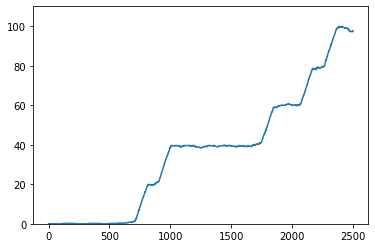

In [6]:
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state, :]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations

t1 = time.time() # Start timer

all_rewards = []
all_violations = []
training_episodes = 2500
training_runs = 5
for i in range(training_runs):
    # Run 5 seeds for an average
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards.append(total/training_runs)

plt.plot(average_rewards)
plt.ylim(0, 110)
plt.show()

### Penalty for Unsafe Actions

Number of steps taken 37030, Violations: 248
Number of steps taken 36861, Violations: 267
Number of steps taken 36107, Violations: 323
Number of steps taken 36483, Violations: 263
Number of steps taken 36125, Violations: 339
Elapsed time is 5.11 seconds.
Average violations per run:  288.0


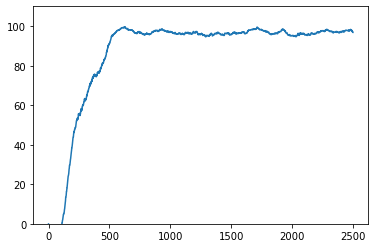

In [7]:
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon: # and any(q_table[state, :])
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            """Intrinsic Punishemnt: Penalty given if unsafe action taken."""
            if terminated and reward != 1:
                # Penalty if an unsafe action is taken.
                reward = -0.1
            elif reward != 1:
                # Small negative reward for each step taken that is not a reward or unsafe action.
                # Without this the agent does not reach the goal, as unsafe actions propagate negative rewards.
                reward = -0.01
                
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations


t1 = time.time() # Start timer

all_rewards = []
all_violations = []
training_episodes = 2500
training_runs = 5
for i in range(training_runs):
    # Run 5 seeds for an average
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_pen = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_pen.append(total/training_runs)

plt.plot(average_rewards_pen)
plt.ylim(0, 110)
plt.show()

### Catastrophic Avoidance Shield

Number of steps taken 40620, Violations: 29
Number of steps taken 42739, Violations: 28
Number of steps taken 42536, Violations: 32
Number of steps taken 40428, Violations: 29
Number of steps taken 42183, Violations: 30
Elapsed time is 6.14 seconds.
Average violations per run:  29.6


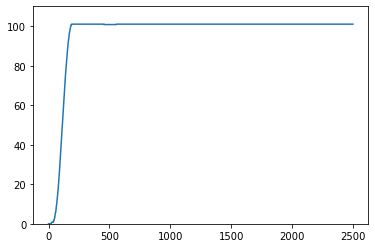

In [8]:
class catastrophy_shield:
    def __init__(self, actions):
        self.catastrophies = {}
        self.actions = actions
        
    def add_catastrophy(self, state, action):
        if state not in self.catastrophies:
            # If this state is not in dictionary, add it, with action in a list.
            self.catastrophies[state] = [action]
        elif action not in self.catastrophies[state]:
            # If state is in the dictionary, but action is not in the state, add it.
            self.catastrophies[state].append(action)
        else:
            pass
            # print(f"[IN SHIELD] Error: {state, action} is already in catastrophy dictionary.")
    
    def is_state_action_safe(self, state, action):
        # Checks if an action is safe. Returns True if it is, False if it is not.
        if state in self.catastrophies and action in self.catastrophies[state]:
            return False
        return True
    
    def unsafe_actions_in_state(self, state):
        # Checks which actions are unsafe in a state. Returns 
        if state in self.catastrophies:
            return self.catastrophies[state]
        else:
            raise Exception("State not in catastrophies dictionary")
    
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human" if render else None) 
    # generate_random_map(size=8) or map_name="8x8"
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
        actions = [0,1,2,3] # Actions the agent may take
        shield = catastrophy_shield(actions)
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state, :]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter
            
            # Shield checks action
            safe = shield.is_state_action_safe(state, action)
            if safe:
                # No further action needed
                pass
            else:
                unsafe_actions = shield.unsafe_actions_in_state(state)
                # Get actions in q-table ranked and choose highest safe option.
                potential_actions = []
                for i in actions:
                    if i not in unsafe_actions:
                        potential_actions.append([q_table[state][i], i])
                # The action of the potential action with highest q_value, random if all values are 0.
                if len(potential_actions) == 0:
                    # If no safe actions available, do unsafe action regardless.
                    pass
                else:
                    if max(potential_actions)[0] == 0:
                        action = random.choice(potential_actions)[1]
                    else:
                        action = max(potential_actions)[1]
            
            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # If action resulted in a catastrophy, add it to the shield.
            if terminated and reward != 1:
                shield.add_catastrophy(state, action)
            
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (float(reward) + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.01.
        epsilon = max(epsilon - decay, 0.01)

        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations

t1 = time.time() # Start timer

all_rewards = []
all_violations = []
training_episodes = 2500
training_runs = 5
for i in range(training_runs):
    # Run 5 seeds for an average
    rewards, violations = frozen_lake(training_episodes)
    # rewards = cumulative_reward(rewards) # Make the rewards cumalative.
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_ca = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_ca.append(total/training_runs)

plt.plot(average_rewards_ca)
plt.ylim(0, 110)
plt.show()

### Graph of results

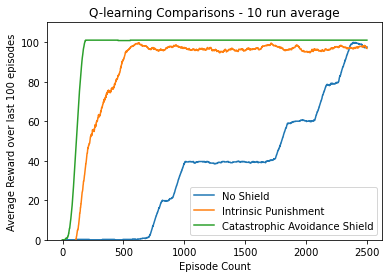

In [9]:
plt.title("Q-learning Comparisons - 10 run average")
plt.xlabel("Episode Count")
plt.ylabel("Average Reward over last 100 episodes")
plt.plot(average_rewards, label="No Shield")
plt.plot(average_rewards_pen, label="Intrinsic Punishment")
plt.plot(average_rewards_ca, label="Catastrophic Avoidance Shield")
plt.legend(loc="lower right")
plt.ylim(0, 110)
plt.show()

### Testing with Slippery set to True

Unshielded Q-Learning
Number of steps taken 1666402, Violations: 12610
Number of steps taken 1777077, Violations: 11216
Number of steps taken 1734887, Violations: 11912
Number of steps taken 1758304, Violations: 11470
Number of steps taken 1744892, Violations: 11996
Elapsed time is 247.93 seconds.
Average violations per run:  11840.8

Penalty for Unsafe Actions
Number of steps taken 1762914, Violations: 11297
Number of steps taken 1758367, Violations: 11284
Number of steps taken 1760892, Violations: 11523
Number of steps taken 1754061, Violations: 11635
Number of steps taken 1753342, Violations: 11523
Elapsed time is 252.17 seconds.
Average violations per run:  11452.4

Catastrophy Avoidance Shield
Number of steps taken 1928086, Violations: 7021
Number of steps taken 1932038, Violations: 6772
Number of steps taken 1931654, Violations: 6634
Number of steps taken 1939137, Violations: 6790
Number of steps taken 1938843, Violations: 6976
Elapsed time is 291.37 seconds.
Average violations p

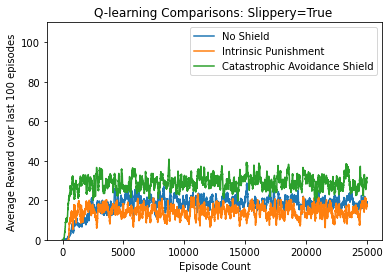

In [66]:
training_episodes = 25000
training_runs = 5

"""Standard Q-learning"""
print("Unshielded Q-Learning")
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state, :]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations


t1 = time.time() # Start timer

all_rewards = []
all_violations = []
for i in range(training_runs):
    # Run 5 seeds for an average
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)
print()
average_rewards = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards.append(total/training_runs)

"""Penalty for unsafe actions"""
print("Penalty for Unsafe Actions")
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    def sum_rewards(episodes_completed):
        """Returns the reward for last 100 episodes for each episode, to give the success rate of the algorithm.
           The maximum is 100, so a 0-100 scale is created, with 100 being the perfect score."""
        sum_of_rewards = np.zeros(episodes_completed)
        for i in range(episodes_completed):
            # Rewards for last 100 episodes
            sum_of_rewards[i] = np.sum(reward_per_episode[max(0, i - 100):(i+1)])

        return sum_of_rewards
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon: # and any(q_table[state, :])
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            """Intrinsic Punishemnt: Penalty given if unsafe action taken."""
            if terminated and reward != 1:
                # Penalty if an unsafe action is taken.
                reward = -0.1
            elif reward != 1:
                # Small negative reward for each step taken that is not a reward or unsafe action.
                # Without this the agent does not reach the goal, as unsafe actions propagate negative rewards.
                reward = -0.01
                
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.02.
        epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(episodes_completed), violations
    # return reward_per_episode, violations


t1 = time.time() # Start timer

all_rewards = []
all_violations = []
for i in range(training_runs):
    # Run 5 seeds for an average
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)
print()
average_rewards_pen = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_pen.append(total/training_runs)

"""Catastrophy Avoidance Shield"""
print("Catastrophy Avoidance Shield")
class catastrophy_shield:
    def __init__(self, actions):
        self.catastrophies = {}
        self.actions = actions
        
    def add_catastrophy(self, state, action):
        if state not in self.catastrophies:
            # If this state is not in dictionary, add it, with action in a list.
            self.catastrophies[state] = [action]
        elif action not in self.catastrophies[state]:
            # If state is in the dictionary, but action is not in the state, add it.
            self.catastrophies[state].append(action)
        else:
            pass
            # print(f"[IN SHIELD] Error: {state, action} is already in catastrophy dictionary.")
    
    def is_state_action_safe(self, state, action):
        # Checks if an action is safe. Returns True if it is, False if it is not.
        if state in self.catastrophies and action in self.catastrophies[state]:
            return False
        return True
    
    def unsafe_actions_in_state(self, state):
        # Checks which actions are unsafe in a state. Returns 
        if state in self.catastrophies:
            return self.catastrophies[state]
        else:
            raise Exception("State not in catastrophies dictionary")
    
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="human" if render else None) 
    # generate_random_map(size=8) or map_name="8x8"
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.5 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
        actions = [0,1,2,3] # Actions the agent may take
        shield = catastrophy_shield(actions)
        
    reward_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state, :]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter
            
            # Shield checks action
            safe = shield.is_state_action_safe(state, action)
            if safe:
                # No further action needed
                pass
            else:
                unsafe_actions = shield.unsafe_actions_in_state(state)
                # Get actions in q-table ranked and choose highest safe option.
                potential_actions = []
                for i in actions:
                    if i not in unsafe_actions:
                        potential_actions.append([q_table[state][i], i])
                # The action of the potential action with highest q_value, random if all values are 0.
                if len(potential_actions) == 0:
                    # If no safe actions available, do unsafe action regardless.
                    pass
                else:
                    if max(potential_actions)[0] == 0:
                        action = random.choice(potential_actions)[1]
                    else:
                        action = max(potential_actions)[1]
            
            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # If action resulted in a catastrophy, add it to the shield.
            if terminated and reward != 1:
                shield.add_catastrophy(state, action)
            
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (float(reward) + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

        # Decrease epsilon after each episode to min of 0.01.
        epsilon = max(epsilon - decay, 0.01)

        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations
    # return reward_per_episode, violations

t1 = time.time() # Start timer

all_rewards = []
all_violations = []
for i in range(training_runs):
    # Run 5 seeds for an average
    rewards, violations = frozen_lake(training_episodes)
    # rewards = cumulative_reward(rewards) # Make the rewards cumalative.
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_ca = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_ca.append(total/training_runs)
  

plt.title("Q-learning Comparisons: Slippery=True ")
plt.xlabel("Episode Count")
plt.ylabel("Average Reward over last 100 episodes")
plt.plot(average_rewards, label="No Shield")
plt.plot(average_rewards_pen, label="Intrinsic Punishment")
plt.plot(average_rewards_ca, label="Catastrophic Avoidance Shield")
plt.legend(loc="upper right")
plt.ylim(0, 110)
plt.show()